In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigs, expm_multiply
from numpy import linalg as LA
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import os
import matplotlib
# from optimparallel import minimize_parallel
%matplotlib inline

In [4]:
x = np.random.randint(low=1, high=1000)
x

29

In [19]:
size = 50
high = 100
it = 1000

l = np.random.randint(low=1, high=high, size=size)
probs = []
for i in range(it):
    sum = 0
    x = np.random.randint(low=1, high=high)
    for j in l:
        if x < j:
            sum += 1
    probs.append(sum/len(l))
print(np.mean(np.array(probs)))

0.52836


In [2]:
def FlipFlop(n, i, j):
    v = list(format(n, '0{}b'.format(L)))
    if (v[i] != '0' and v[j] != '1'):
        v[i] = '0'
        v[j] = '1'
        return int(''.join(v), 2)
    else:
        return -1
        
def Raise(n, i):
    v = list(format(n, '0{}b'.format(L)))
    # checking mod here, unsure why since accesses aren't modded
    if (v[i] != '1'):
        v[i] = '1'
        return int(''.join(v), 2)
    else:
        return -1

L = 6

Sz = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        sprs[j, j] = 1-2*int(format(j, '0{}b'.format(L))[i])
    Sz.append(sprs)
SzTot = sum(Sz)

Sp = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        h = Raise(j, i)
        if (h != -1):
            sprs[h, j] = 1
    Sp.append(sprs)

Heis = []
for i in range(L):
    _ = []
    for k in range(L):
        sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
        for j in range(2**L):
            h = FlipFlop(j, i, k)
            v = lambda i: 1-2*int(format(j, '0{}b'.format(L))[i])
            if (h != -1):
                sprs[j, h] = 2
                sprs[h, j] = 2
            sprs[j, j] = v(i) * v(k)
        _.append(sprs)    
    Heis.append(_)

Sm = [Sp[i].T for i in range(L)]
Sx = [Sp[i]+Sm[i] for i in range(L)]
Sy = [-1j*Sz[i] @ Sx[i] for i in range(L)]
SxTot = sum(Sx)
SyTot = sum(Sy)

C:\Users\nfber\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [39]:
H = sum([Heis[i][(i+1)%L] for i in range(L-1)]) / 4
# H = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)])) / 4 # H plus Z_i Z_{i+2}

tf = 28
dt = tf / 300
Nt = int(tf / dt)
# c = ['1','1','0'] 
c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
UnitVector = lambda c: np.eye(2**L)[c]
init = UnitVector(int(''.join(c), 2))

def ExactTimeEvolution(dt, nt, init):
    revos = [np.zeros(2**L) for i in range(nt+1)]
    revos[0] = init
    for i in range(nt):
        # scipy.sparse.linalg.expm_multiply
        revos[i+1] = expm_multiply(-1j * H * dt, revos[i])
    return revos

revos = ExactTimeEvolution(dt, Nt, init)

Szt = []
for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ (Sz[0]) @ revos[i] / 2)

C:\Users\nfber\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


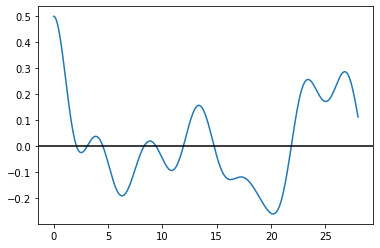

In [40]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.axhline(y=0, color='k')

In [41]:
def TrotterEvolve(dt, nt, init):
    if (L % 2 == 0):
        UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L-1, 2)]) / 4) # 0 indexing, this is actually even indices
        UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L-1, 2)]) / 4) # range(1, L, 2) for periodic bdy conditions
        UTrotter = UOdd @ UEven
        # UZ = expm(-1j * dt * sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) / 2)
        # UTrotter = UEven @ UOdd @ UZ
    else:
        UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L-1, 2)]) / 4)
        UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L, 2)]) / 4)
        # UBdy = expm(-1j * dt * Heis[L-1][0] / 4)
        UTrotter = UOdd @ UEven # UBdy @ UOdd @ UEven
    psi_trot = init
    for i in range(nt):
        psi_trot = UTrotter @ psi_trot
    return psi_trot

def Ansatz(params, p):
    psi_ansz = init
    for i in range(p): # len(params) // L
        for j in range(1, L-1, 2):
            psi_ansz = expm(-1j * params[((L-1)*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
        for j in range(0, L-1, 2):
            psi_ansz = expm(-1j * params[((L-1)*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
    return psi_ansz

# def Ansatz(params, p):
#     psi_ansz = init
#     for i in range(p): # len(params) // L
#         for j in range(0, L, 2):
#             # odd first, then even. Apply to left
#             psi_ansz = expm(-1j * params[(2*L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
#         for j in range(1, L, 2):
#             psi_ansz = expm(-1j * params[(2*L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
#         for j in range(L):
#             psi_ansz = expm(-1j * params[(2*L*i)+L+j] * diags(Heis[j][(j+2)%L].diagonal()).tocsc()) @ psi_ansz
#     return psi_ansz

def Loss(x, target, O):
    psi_ansz = Ansatz(x)
    Sz_ansz = np.conj(psi_ansz) @ (O) @ psi_ansz / 2
    Sz_ex = np.conj(target) @ (O) @ target / 2
    return abs(Sz_ansz - Sz_ex)

def Fidelity(x, target, p):
    psi_ansz = Ansatz(x, p)
    return 1 - abs(np.conj(target) @ psi_ansz)**2

In [53]:
ntrot = 7
dtrot = 0.4
tf_vtc = 35
tf = 28
shots = 2**15
op = Sz[0]

Szt = []
for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ op @ revos[i] / 2)

VTDStepList = pd.read_csv(f'VTD_results/shots_variation_loschmidt_6/VTD_results_{tf_vtc}_{L}_{ntrot}_{dtrot}_{shots}.csv', index_col=0)
VTDStepList = VTDStepList.applymap(lambda x: complex(x))
VTDSz = [np.array(np.conj(VTDStepList.iloc[i])) @ op @ np.array(VTDStepList.iloc[i]) / 2 for i in range(len(VTDStepList))]

TrotterFixStepList = [init]
ts = [i*ntrot*dtrot for i in range(int(np.ceil(tf / (ntrot * dtrot)))+1)]

for i in range(int(np.ceil(tf / (ntrot * dtrot)))):
    TrotterFixStepList.append(TrotterEvolve(dtrot, ntrot, TrotterFixStepList[i]))
TrotterFixStepSz = [np.conj(TrotterFixStepList[i]) @ op @ TrotterFixStepList[i] / 2 for i in range(len(TrotterFixStepList))]

BadTrotterFixStepList = [init]
for i in range(Nt):
    BadTrotterFixStepList.append(TrotterEvolve((i+1)*dt/(ntrot*3), ntrot*3, init))
BadTrotterFixStepSz = [np.conj(BadTrotterFixStepList[i]) @ op @ BadTrotterFixStepList[i] / 2 for i in range(len(BadTrotterFixStepList))]

BestCompression = [init]
for i in range(len(VTDStepList)):
    BestCompression.append(TrotterEvolve(dtrot, ntrot, VTDStepList.iloc[i]))

C:\Users\nfber\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\nfber\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '32768 shots')

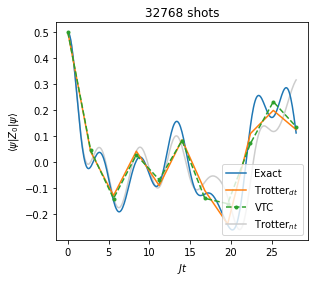

In [54]:
# plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1, 1, figsize=(4.5,4))

plt.plot([i*dt for i in range(len(revos))], Szt, label="Exact")
plt.plot(ts, TrotterFixStepSz, label="Trotter$_{dt}$")
plt.plot(VTDStepList.index, VTDSz, linestyle="--", marker=".", label="VTC")
plt.plot([i*dt for i in range(len(BadTrotterFixStepList[:]))], BadTrotterFixStepSz[:], label="Trotter$_{nt}$", c='#CDCDCD', zorder=0)
plt.legend(loc="lower right")
plt.xlabel('$Jt$')
plt.ylabel('$\langle \psi | Z_0 | \psi \\rangle$')
plt.title(f'{shots} shots')

# plt.savefig(f'VTD_results/full_noise_loschmidt/VTC_expectation_{shots}', dpi=300, transparent=False, bbox_inches='tight')


Text(0.5, 1.0, '32768 shots')

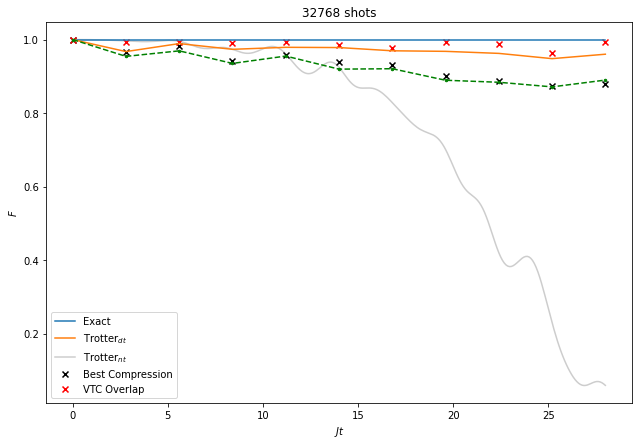

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10.5,7))

ExFidelity = [abs(np.conj(revos[i]) @ revos[i])**2 for i in range(len(revos))]
BadTrotterFidelity = [abs(np.conj(revos[i]) @ BadTrotterFixStepList[i])**2 for i in range(len(BadTrotterFixStepList))]

revos_ = [expm(-1j * H * t) @ init for t in ts]

TrotterFidelity = [abs(np.conj(revos_[i]) @ TrotterFixStepList[i])**2 for i in range(len(TrotterFixStepList))]
VTDFidelity = [abs(np.conj(revos_[i]) @ np.array(VTDStepList.iloc[i]))**2 for i in range(len(VTDStepList))]
BestCompressionFidelity = [abs(np.conj(revos_[i]) @ np.array(BestCompression[i]))**2 for i in range(len(BestCompression[1:]))]
VTDBestCompressionFidelity = [abs(np.conj(BestCompression[i]) @ np.array(VTDStepList.iloc[i]))**2 for i in range(len(VTDStepList))]

ax.plot([i*dt for i in range(len(revos))], ExFidelity, label="Exact")
ax.plot(ts, TrotterFidelity, label="Trotter$_{dt}$")
# ax.errorbar(VTDStepList.index, mean, yerr=err, linestyle="--", marker='.', label="VTC", markersize=5, c='g')

ax.plot(VTDStepList.index, VTDFidelity, linestyle="--", marker='.', markersize=5, c='g')
ax.scatter([i*dtrot*ntrot for i in range(len(BestCompressionFidelity))], BestCompressionFidelity, label="Best Compression", marker='x', c='k')
ax.scatter([i*dtrot*ntrot for i in range(len(VTDBestCompressionFidelity))], VTDBestCompressionFidelity, label="VTC Overlap", marker='x', c='r')


ax.plot([i*dt for i in range(len(revos))], BadTrotterFidelity, label="Trotter$_{nt}$", c='#CDCDCD', zorder=0)
ax.legend(loc='lower left')
ax.set_ylabel('$F$')
ax.set_xlabel('$Jt$')

ax.set_title(f'{shots} shots')

# plt.savefig(f'VTD_results/real_device/VTC_fidelity_{shots}', dpi=300, transparent=False, bbox_inches='tight')
# plt.savefig(f'figures/combined_VTD.svg', dpi=300, transparent=False, bbox_inches='tight')


In [40]:
ntrot = 2
dtrot = 1.0
tf = 20
shots = 2**13
op = Sz[0]

ts = [i*ntrot*dtrot for i in range(int(np.ceil(tf / (ntrot * dtrot)))+1)]

fidelities = []
for i in range(50):
    if os.path.isfile(f'VTD_results/error_bars/VTD_results_{tf}_{L}_{ntrot}_{dtrot}_{shots}_{i}.csv'):
        VTDStepList = pd.read_csv(f'VTD_results/error_bars/VTD_results_{tf}_{L}_{ntrot}_{dtrot}_{shots}_{i}.csv', index_col=0)
        VTDStepList = VTDStepList.applymap(lambda x: complex(x))

        revos_ = [expm(-1j * H * t) @ init for t in ts]

        VTDFidelity = [abs(np.conj(revos_[i]) @ np.array(VTDStepList.iloc[i]))**2 for i in range(len(VTDStepList))]
        fidelities.append(VTDFidelity)

err = np.std(np.array(fidelities), axis=0)
mean = np.mean(np.array(fidelities), axis=0)
print(err)
print(mean)

[0.         0.01932786 0.02682697 0.01696717 0.03712318 0.04569909
 0.04031314 0.05443713 0.06314768 0.06386445 0.06709282]
[1.         0.94632644 0.93411182 0.97192907 0.92376348 0.91764779
 0.94011395 0.90836409 0.89783545 0.89649951 0.8840228 ]


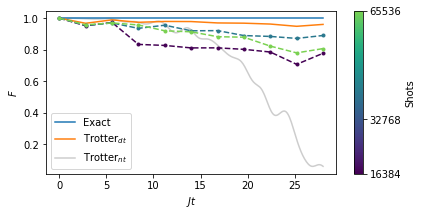

In [52]:
ntrot = 7
dtrot = 0.4
tf_vtc = 35
tf = 28

ts = [i*ntrot*dtrot for i in range(int(np.ceil(tf / (ntrot * dtrot)))+1)]
fig, ax = plt.subplots(1, 1, figsize=(6.5,3))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

fidelities = []
# ii = np.array([2**i for i in range(13, 10, -1)])
ii = np.array([2**i for i in range(14, 17)])
for i in ii:
    if os.path.isfile(f'VTD_results/shots_variation_loschmidt_6/VTD_results_{tf_vtc}_{L}_{ntrot}_{dtrot}_{i}.csv'):
        VTDStepList = pd.read_csv(f'VTD_results/shots_variation_loschmidt_6/VTD_results_{tf_vtc}_{L}_{ntrot}_{dtrot}_{i}.csv', index_col=0)
        VTDStepList = VTDStepList.applymap(lambda x: complex(x))

        revos_ = [expm(-1j * H * t) @ init for t in ts]

        VTDFidelity = [abs(np.conj(revos_[i]) @ np.array(VTDStepList.iloc[i]))**2 for i in range(len(VTDStepList))]
        fidelities.append(VTDFidelity)


color = matplotlib.cm.viridis
color = truncate_colormap(color, 0.0, 0.8)
norm = matplotlib.colors.Normalize(ii.min(), ii.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=color)
# cmap.set_array([])

cbar = plt.colorbar(cmap, ticks=ii)
cbar.set_label('Shots')

ax.set_prop_cycle('color', [color(i) for i in np.linspace(0, 1, len(fidelities))])

ax.plot([i*dt for i in range(len(revos))], ExFidelity, c='#1f77b4', label='Exact')
ax.plot(ts, TrotterFidelity, c='#ff7f0e', label='Trotter$_{dt}$')
ax.plot([i*dt for i in range(len(revos))], BadTrotterFidelity, label='Trotter$_{nt}$', c='#CDCDCD', zorder=0)


for i in range(len(fidelities)):
    ax.plot([i*dtrot*ntrot for i in range(len(fidelities[i]))], fidelities[i], linestyle='--', marker='.')

ax.set_ylabel('$F$')
ax.set_xlabel('$Jt$')

handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], loc='lower left')

ax.legend(loc='lower left')
plt.savefig(f'figures/shots_variation_L6', dpi=300, transparent=False, bbox_inches='tight')


Text(0, 0.5, '$F$')

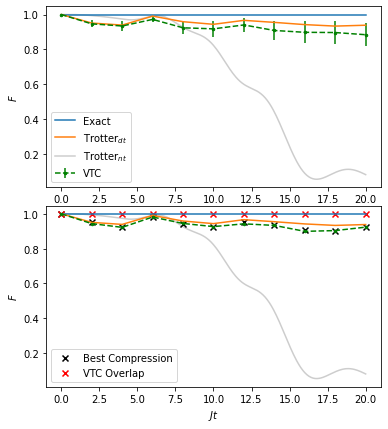

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(6,7), sharey=True)
fig.subplots_adjust(hspace=0.1)

ExFidelity = [abs(np.conj(revos[i]) @ revos[i])**2 for i in range(len(revos))]
BadTrotterFidelity = [abs(np.conj(revos[i]) @ BadTrotterFixStepList[i])**2 for i in range(len(BadTrotterFixStepList))]

revos_ = [expm(-1j * H * t) @ init for t in ts]

TrotterFidelity = [abs(np.conj(revos_[i]) @ TrotterFixStepList[i])**2 for i in range(len(TrotterFixStepList))]
VTDFidelity = [abs(np.conj(revos_[i]) @ np.array(VTDStepList.iloc[i]))**2 for i in range(len(VTDStepList))]
BestCompressionFidelity = [abs(np.conj(revos_[i]) @ np.array(BestCompression[i]))**2 for i in range(len(BestCompression[1:]))]
VTDBestCompressionFidelity = [abs(np.conj(BestCompression[i]) @ np.array(VTDStepList.iloc[i]))**2 for i in range(len(VTDStepList))]

ax[0].plot([i*dt for i in range(len(revos))], ExFidelity, label="Exact")
ax[1].plot([i*dt for i in range(len(revos))], ExFidelity)

ax[0].plot(ts, TrotterFidelity, label="Trotter$_{dt}$")
ax[1].plot(ts, TrotterFidelity)

ax[0].errorbar(VTDStepList.index, mean, yerr=err, linestyle="--", marker='.', label="VTC", markersize=5, c='g')

ax[1].plot(VTDStepList.index, VTDFidelity, linestyle="--", marker='.', markersize=5, c='g')
ax[1].scatter([i*dtrot*ntrot for i in range(len(BestCompressionFidelity))], BestCompressionFidelity, label="Best Compression", marker='x', c='k')
ax[1].scatter([i*dtrot*ntrot for i in range(len(VTDBestCompressionFidelity))], VTDBestCompressionFidelity, label="VTC Overlap", marker='x', c='r')


ax[0].plot([i*dt for i in range(len(revos))], BadTrotterFidelity, label="Trotter$_{nt}$", c='#CDCDCD', zorder=0)
ax[1].plot([i*dt for i in range(len(revos))], BadTrotterFidelity, c='#CDCDCD', zorder=0)

ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')

ax[1].set_xlabel('$Jt$')
ax[0].set_ylabel('$F$')
ax[1].set_ylabel('$F$')

# ax.set_title(f'{shots} shots')

# plt.savefig(f'VTD_results/real_device/VTC_fidelity_{shots}', dpi=300, transparent=False, bbox_inches='tight')
# plt.savefig(f'figures/combined_VTD.svg', dpi=300, transparent=False, bbox_inches='tight')


In [52]:
np.mean(VTDBestCompressionFidelity)

0.9689608260609919

In [21]:
len(TrotterFixStepList)

10